Ideas to make this work:

* run longer chain
* change the chain step sizes
* implement reasonable priors and potentially update likelihoods
* figure out with what probability to accept the next step
* change the number of annuli (not shells!)


In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

% matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 8.0) 

In [156]:
def defineAnnuli(r,nAnn):
    return np.append(0.,np.sort(r)[np.linspace(0,len(r)-1,nAnn).astype(int)][1:])

def labelGalaxies(data,annuli):
    #adds a column to data indicating the galaxy's membership in an annulus
    bla = np.zeros(len(data['r']))
    for i in range(len(annuli)-1):
        bla += i*np.array(np.logical_and(data['r']>annuli[i],data['r']<=annuli[i+1]).astype(int))
    return bla

def galInAnn(data,annuli):
    #calculates the number of galaxies in all the annuli
    return np.array([(data['annuli']==i).sum() for i in range(len(annuli)-1)])

def sigInAnn(data,annuli):
    return [np.std(data['vobs'][data['annuli']==i],ddof=1) for i in range(len(annuli)-1)]



In [157]:
data=pd.read_csv('mock_cluster_4.csv')
data.rename(columns={'Unnamed: 0':'id','0':'origAnn','1':'x','2':'y','3':'z','4':'vobs'},inplace=True)

data['r'] = np.power(np.power(data['x'],2.)+np.power(data['y'],2.),0.5)

nAnn = 20 #number of desired annuli
annuli = defineAnnuli(data['r'],nAnn+1) 

print annuli

#summarize the true data

# number of galaxies per annulus
    
data['annuli']=labelGalaxies(data,annuli)
nData = galInAnn(data,annuli)
sigmaData = sigInAnn(data,annuli)

print nData
print sigmaData

[   0.            1.56247349    2.16977251    3.42965227    5.10062805
    7.74654233   11.24012234   16.92425282   23.85469564   34.64472916
   47.14815397   64.64659462   81.82870312  102.85160642  160.69250602
  211.73549208  272.81301104  380.21848947  513.90598477  681.25847525
  982.44091053]
[50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]
[525.7960516475589, 376.28124905187155, 383.07124176272396, 358.96055477503245, 315.46086291605195, 408.0943747550376, 381.78225532521384, 312.13282180655, 311.7578869361472, 272.8620545805943, 213.4421187383344, 262.0915800482399, 187.45072493468962, 217.08764310751928, 214.6527290233689, 182.63152625120094, 139.90779000787603, 170.52082332946424, 168.8861877266652, 158.1697709405361]


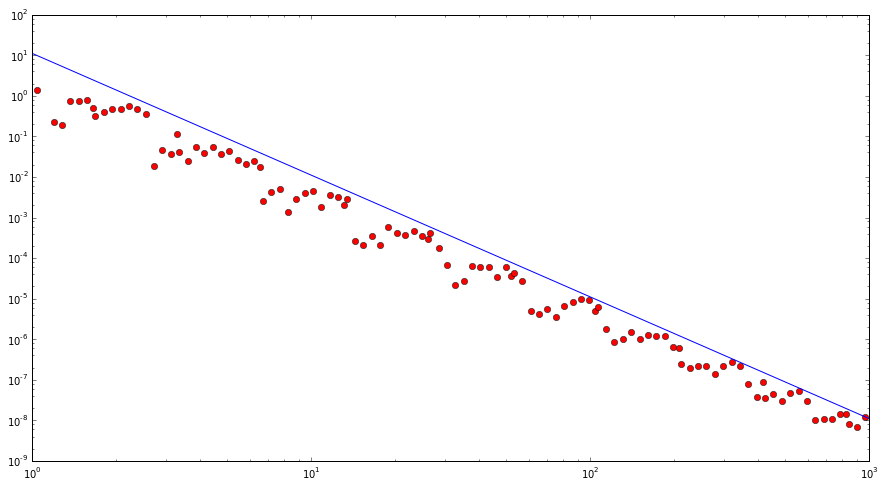

In [195]:
data['rho'] = np.power(np.power(data['x'],2.)+np.power(data['y'],2.)+np.power(data['z'],2.),0.5)

def defineRadii(nTot=1000.,rOut=1000.,nAnn=10,k=3):
    radii = np.array([1.])
    if k==3.:
        nu0 = nTot/(4*np.pi*np.log(rOut))
        c = nTot/(nAnn*4*np.pi*nu0)
    else:
        nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
        c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
        
    for i in range(nAnn):
        if k==3.:
            radii = np.append(radii,np.exp(c+np.log(radii[i])))
        else:
            radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii
    

radii10 = defineRadii()
radii100 = defineRadii(nAnn=100)

#bla1,bla2,bla3 = plt.hist(data['rho'],bins=radii10)
#bla4,bla5,bla6 = plt.hist(data['rho'],bins=radii100)

plt.plot((0.5*(radii10[1:]**3+radii10[:-1]**3))**(1/3.),bla1/(4*np.pi*(radii10[1:]**3-radii10[:-1]**3)),'ro')
plt.plot((0.5*(radii100[1:]**3+radii100[:-1]**3))**(1/3.),bla4/(4*np.pi*(radii100[1:]**3-radii100[:-1]**3)),'ro')
plt.plot(np.logspace(0,3,10),11*np.logspace(0,3,10)**-3)
plt.xscale('log')
plt.yscale('log')

In [193]:
x,y = np.log((0.5*(radii[1:]**3+radii[:-1]**3))**(1/3.)),np.log(bla1/(4*np.pi*(radii[1:]**3-radii[:-1]**3)))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print slope, np.exp(intercept)

-2.86171670462 2.9772245996


In [158]:
def defineShellRadii(nTot=1000.,rOut=1000.,nAnn=10,k=3):
    radii = np.array([1.])
    if k==3.:
        nu0 = nTot/(4*np.pi*np.log(rOut))
        c = nTot/(nAnn*4*np.pi*nu0)
    else:
        nu0 = nTot*(3.-k)/(4*np.pi*(rOut**(3.-k)-1.))
        c = (3-k)*nTot/(4*np.pi*nu0*nAnn)
        
    for i in range(nAnn):
        if k==3.:
            radii = np.append(radii,np.exp(c+np.log(radii[i])))
        else:
            radii = np.append(radii,(c+radii[i]**(3-k))**(1./(3-k)))
    return radii

defineShellRadii()

def nuProfile(Ntot,radii,k=2.9):
    nu0 = Ntot / (4.*np.pi*(nuInt(radii[-1], k)-nuInt(radii[0], k)))
    print nu0
    #print 'nu0:' ,nu0
    return (nu0*(nuInt(radii[1:],k) - nuInt(radii[:-1],k))).astype(int)

def sigmaProfile(radii,sigMax=1000,k=-.2):
    return sigMax*(0.5*(radii[1:]+radii[:-1]))**k

In [159]:
def createMockData(Ntot=1000,rOut=1000.,nAnn=10,sigMax=1000,kindex=3.,sigmaindex=-0.2): #total Ngals, no of shells
    clusterData = np.zeros((2*Ntot,2))
    counter=0
    radii = defineShellRadii(Ntot,rOut,nAnn,kindex)
    #density = nuProfile(Ntot,radii,k=kindex)
    sig = sigmaProfile(radii,sigMax,k=sigmaindex)
    
    for shell,dens in enumerate(np.random.poisson(Ntot/nAnn*np.ones(nAnn))):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        theta = np.arccos(cosTheta)
        u = np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens) #cuberoot([rin,rout])
        r = np.power(u,1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*cosTheta
        
        radius = np.power(np.power(x,2.)+np.power(y,2.),0.5)
        #generate velocities
        
        speed = sig[shell]*np.random.randn(dens)
        #phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        #theta = np.arccos(cosTheta)
        
        v=speed*cosTheta
        
        #replace with vstack,append
        clusterData[counter:counter+dens]=np.hstack((radius.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    #print 'Created mock data with '+str(counter)+' galaxies.'
    return pd.DataFrame(clusterData[:counter],columns=['r','vobs'])

In [160]:
#a single "mcmc step"
kIndex = 2.6
sigmaIndex = 0.
sigMax = 500

def mcmcStep(annuli,kInd,sInd,sMaxInd):
    mockData = createMockData(len(data['r']),np.amax(data['r']),10,sigMax,kIndex,sigmaIndex)
    mockData['annuli'] = labelGalaxies(mockData,annuli)
    return galInAnn(mockData,annuli),sigInAnn(mockData,annuli)

print mcmcStep(annuli,kIndex,sigmaIndex,sigMax)

(array([  4,   2,  15,  21,  41,  21,  26,  48,  49,  47,  56,  37,  45,
       109,  61,  63,  95,  81,  80,  71]), [265.28185954742685, 319.9653611565754, 251.90259268755037, 290.5459102371181, 285.84836339927523, 273.7912058954671, 405.37190296421016, 278.72594422532086, 279.82126517541747, 405.8788350129415, 327.8068833092556, 251.31706469114175, 267.6128619924153, 315.41529679593214, 331.58895315011944, 269.29344835314004, 317.17248148567666, 305.2546807333365, 260.6551139669465, 282.37973992541447])


In [161]:
#all log likelihoods

#make a table of log(n!)-s for n=1,...
factorialTable = np.cumsum(np.append(0,[np.log(i) for i in range(1,len(data['r']))]))

def logPriorNu(k):
    #starting gaussian
    nu0 = 3. #mean prior density index
    sigma = 1.
    return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorSigma(k):
    #starting gaussian
    nu0 = -.2 #mean prior sigma index
    sigma = 0.1
    return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorSigmaNorm(k):
    #starting gaussian
    nu0 = 1000 #mean prior sigma index
    sigma = 500
    return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)
 

def logLikelihoodNu(prediction,data):
    return np.sum(data*np.log(prediction)-prediction-factorialTable[data])

def logLikelihoodSigma(vObs,vPred,nPred):
    # distribution of variances is chisq, as shown, for example, at
    # https://onlinecourses.science.psu.edu/stat414/node/174
    return np.sum(np.log(stats.chi2.pdf((nPred-1.)*np.power(vObs,2.)/np.power(vPred,2.),nPred-1)))

def logPosterior(vObs,vPred,nObs,nPred,kInd,sigmaInd,sigmaNorm):
    return logPriorNu(kInd)+logPriorSigma(sigmaInd)+logPriorSigmaNorm(sigmaNorm)+\
           logLikelihoodNu(nPred,nObs)+logLikelihoodSigma(vObs,vPred,nPred)

In [162]:
while True:
    dens,sig = mcmcStep(annuli,3,-0.2,1000)
    if np.isnan(sig).any():
        continue
    else:
        #print dens,sig
        break

while True:
    hlp1,hlp2 = mcmcStep(annuli,3,-0.2,1000)
    if np.isnan(hlp2).any():
        continue
    else:
        #print hlp1,hlp2
        dens,sig = np.vstack((dens,hlp1)),np.vstack((sig,hlp2))
    if dens.shape[0]>10:
        break
        
nPred,sigPred = np.mean(dens,axis=0),np.mean(sig,axis=0)

print nPred.sum()

1016.36363636


In [167]:
# Set up parameter grids:
npix = 500
amin,amax = -5,10.
bmin,bmax = -2.,1.
agrid = np.linspace(amin,amax,npix)
bgrid = np.linspace(bmin,bmax,npix)
logprob = np.zeros([npix,npix])

# Loop over parameters, computing unnormlized log posterior PDF:
for i,a in enumerate(agrid):
    for j,b in enumerate(bgrid):
        logprob[j,i] = logPosterior(sigmaData,sigPred,nData,nPred,a,b,1000)

# Normalize and exponentiate to get posterior density:
Z = np.max(logprob)
prob = np.exp(logprob - Z)
norm = np.sum(prob)
prob /= norm

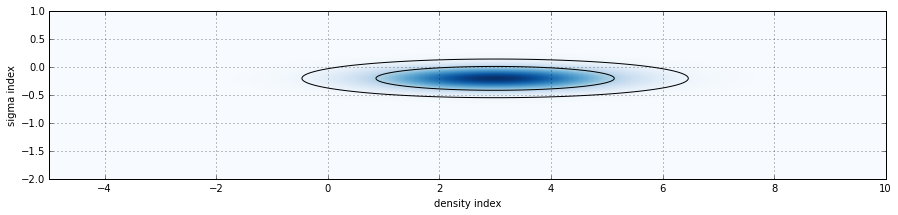

In [168]:
sorted = np.sort(prob.flatten())
C = sorted.cumsum()

# Find the pixel values that lie at the levels that contain
# 68% and 95% of the probability:
lvl68 = np.min(sorted[C > (1.0 - 0.68)])
lvl95 = np.min(sorted[C > (1.0 - 0.95)])

plt.imshow(prob, origin='lower', cmap='Blues', interpolation='none', extent=[amin,amax,bmin,bmax])
plt.contour(prob,[lvl68,lvl95],colors='black',extent=[amin,amax,bmin,bmax])
plt.grid()
plt.xlabel('density index')
plt.ylabel('sigma index')

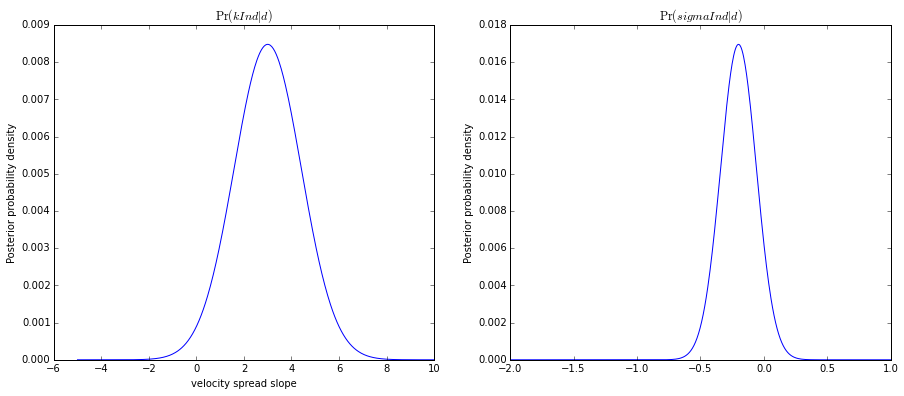

In [169]:
prob_kInd_given_data = np.sum(prob,axis=0) # Approximate the integral as a sum
prob_sigmaInd_given_data = np.sum(prob,axis=1) # Approximate the integral as a sum

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

left = ax[0].plot(agrid, prob_kInd_given_data)
ax[0].set_title('${\\rm Pr}(kInd|d)$')
ax[0].set_xlabel('galaxy density slope')
ax[0].set_ylabel('Posterior probability density')

right = ax[1].plot(bgrid, prob_sigmaInd_given_data)
ax[1].set_title('${\\rm Pr}(sigmaInd|d)$')
ax[0].set_xlabel('velocity spread slope')
ax[1].set_ylabel('Posterior probability density')

In [170]:
def compress_1D_pdf(x,pr,ci=68,dp=1):
    
    # Interpret credible interval request:
    low  = (1.0 - ci/100.0)/2.0    # 0.16 for ci=68
    high = 1.0 - low               # 0.84 for ci=68

    # Find cumulative distribution and compute percentiles:
    cumulant = pr.cumsum()
    pctlow = x[cumulant>low].min()
    median = x[cumulant>0.50].min()
    pcthigh = x[cumulant>high].min()
    
    # Convert to error bars, and format a string:
    errplus = np.abs(pcthigh - median)
    errminus = np.abs(median - pctlow)
    
    report = "$ "+str(round(median,dp))+"^{+"+str(round(errplus,dp))+"}_{-"+str(round(errminus,dp))+"} $"
    
    return report

print("kInd = ",compress_1D_pdf(agrid,prob_kInd_given_data,ci=68,dp=2))

print("sigmaInd = ",compress_1D_pdf(bgrid,prob_sigmaInd_given_data,ci=68,dp=2))

('kInd = ', '$ 3.0^{+1.41}_{-1.41} $')
('sigmaInd = ', '$ -0.2^{+0.14}_{-0.14} $')


In [120]:

nRuns = 1000
burn=100

chain = []
probs = []
naccept = 0
    
print 'Running MC for', nRuns, 'steps'


nOld,sigmaOld = mcmcStep(annuli,kIndex,sigmaIndex,sigMax)
lOld = logPriorNu(kIndex)+logPriorSigma(sigmaIndex)+logLikelihoodNu(nOld,nData)+\
       logLikelihoodSigma(sigmaData,sigmaOld,nOld)+logPriorSigmaNorm(sigMax)

kOld = kIndex
sIndOld = sigmaIndex
sMaxOld = sigMax

outputStep = 50

for i in range(burn+nRuns):
    if i%outputStep==0: 
        print 'Iteration '+str(i)+'/'+str(burn+nRuns)
    kNew = kOld+0.2*np.random.randn()
    sIndNew = sIndOld+0.02*np.random.randn()
    sMaxNew = sMaxOld+10*np.random.randn()
    nMock,sigmaMock = mcmcStep(annuli,kNew,sIndNew,sMaxNew)
    lNew=logPriorNu(kNew)+logPriorSigma(sIndNew)+logLikelihoodNu(nMock,nData)+\
         logLikelihoodSigma(sigmaData,sigmaMock,nMock)+logPriorSigmaNorm(sMaxNew)
    
    print 'lOld = '+str(lOld)
    #print 'lNew = '+str(lNew)
    
    if ((lNew - lOld) > np.log(np.random.uniform())):
        # accept
        kOld = kNew
        sIndOld = sIndNew
        sMaxOld = sMaxNew
        lOld = lNew
        if (i > burn): #measure acceptance rate after burn-in only
            naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((kOld,sIndOld,sMaxOld))

print 'Acceptance fraction:', naccept/float(nRuns)
#return chain[burn_in:]
    

Running MC for 1000 steps
Iteration 0/1100
lOld = -539.979659318
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -540.591360046
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -510.462808611
lOld = -508.622745984
lOld = -508.622745984
lOld = -508.622745984
lOld = -508.622745984
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499.255854808
lOld = -499

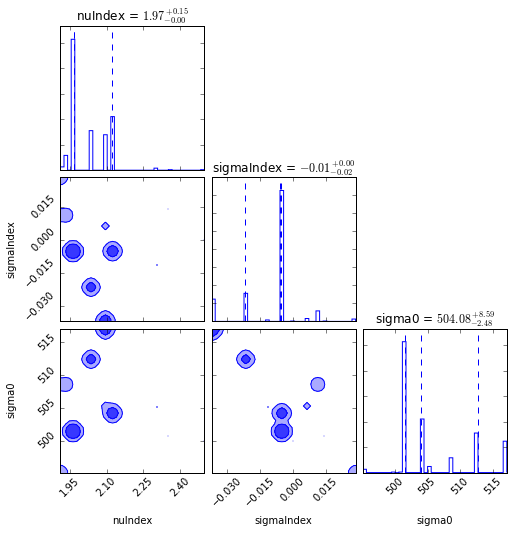

In [112]:
import corner
corner.corner(chain, labels=['nuIndex','sigmaIndex','sigma0'],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()